In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd 
import numpy as np 
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import scipy.io
# Usually not needed in Kaggle, but included for completeness
import h5py  # Important: newer .mat files use HDF5 format

In [3]:
data_dir = '/kaggle/input/nasa-battery-dataset'  
mat_files = [f for f in os.listdir(data_dir) if f.endswith('.mat')]
mat_files.sort()
print(mat_files)

['B0005.mat', 'B0006.mat', 'B0007.mat', 'B0018.mat', 'B0025.mat', 'B0026.mat', 'B0027.mat', 'B0028.mat', 'B0029.mat', 'B0030.mat', 'B0031.mat', 'B0032.mat', 'B0033.mat', 'B0034.mat', 'B0036.mat', 'B0038.mat', 'B0039.mat', 'B0040.mat', 'B0041.mat', 'B0042.mat', 'B0043.mat', 'B0044.mat', 'B0045.mat', 'B0046.mat', 'B0047.mat', 'B0048.mat', 'B0049.mat', 'B0050.mat', 'B0051.mat', 'B0052.mat', 'B0053.mat', 'B0054.mat', 'B0055.mat', 'B0056.mat']


In [4]:
len(mat_files)

34

In [5]:
def parse_battery(file_path):
    # Load the .mat file
    mat = scipy.io.loadmat(file_path)
    battery_id = os.path.basename(file_path).replace('.mat', '')
    
    # Access battery struct (e.g., 'B0005')
    battery = mat[battery_id][0, 0]
    
    # Get all cycles
    cycles = battery['cycle'][0]
    data_list = []

    for i in range(len(cycles)):
        cycle = cycles[i]

        # Get cycle type (charge/discharge/impedance)
        cycle_type = cycle['type'][0]
        if isinstance(cycle_type, np.ndarray):
            cycle_type = ''.join(cycle_type)
        else:
            cycle_type = str(cycle_type).strip()
        
        if cycle_type != 'discharge':
            continue

        # Access 'data' struct
        try:
            data_struct = cycle['data'][0]
            voltage = data_struct['Voltage_measured'][0].ravel()
            current = data_struct['Current_measured'][0].ravel()
            temperature = data_struct['Temperature_measured'][0].ravel()
            time_sec = data_struct['Time'][0].ravel()
        except Exception as e:
            print(f"[{battery_id} - cycle {i}] Error: {e}")
            continue

        # Ensure consistent length
        if len(voltage) == 0 or not (len(voltage) == len(current) == len(temperature) == len(time_sec)):
            continue

        # Compute discharge capacity in Amp-hours (Ah)
        try:
            capacity = np.abs(np.trapz(current, time_sec)) / 3600  # convert from As to Ah
        except Exception as e:
            print(f"[{battery_id} - cycle {i}] Capacity calc error: {e}")
            capacity = np.nan

        # Save cycle-level summary
        cycle_summary = {
            'battery_id': battery_id,
            'cycle_index': i,
            'avg_voltage': np.mean(voltage),
            'min_voltage': np.min(voltage),
            'max_voltage': np.max(voltage),
            'avg_current': np.mean(current),
            'max_current': np.max(current),
            'avg_temperature': np.mean(temperature),
            'capacity_ah': capacity
        }
        data_list.append(cycle_summary)

    return pd.DataFrame(data_list)

In [6]:
all_dfs = []
mat_files = [f for f in os.listdir(data_dir) if f.endswith('.mat')]
mat_files.sort()

for mat_file in mat_files:
    path = os.path.join(data_dir, mat_file)
    print(f"🔋 Processing {mat_file}...")
    try:
        df = parse_battery(path)
        if not df.empty:
            all_dfs.append(df)
            print(f"{mat_file}: {len(df):,} data points")
        else:
            print(f"{mat_file}: No discharge cycles found")
    except Exception as e:
        print(f"{mat_file}: Error: {e}")

# Final dataset
if all_dfs:
    final_df = pd.concat(all_dfs, ignore_index=True)
    print(f"\n🚀 Final dataset shape: {final_df.shape}")
    final_df.to_csv('nasa_battery_discharge_data.csv', index=False)
    print("💾 Saved to 'nasa_battery_discharge_data.csv'")
else:
    print("❌ No data was loaded.")

🔋 Processing B0005.mat...
B0005.mat: 168 data points
🔋 Processing B0006.mat...
B0006.mat: 168 data points
🔋 Processing B0007.mat...
B0007.mat: 168 data points
🔋 Processing B0018.mat...
B0018.mat: 132 data points
🔋 Processing B0025.mat...
B0025.mat: 28 data points
🔋 Processing B0026.mat...
B0026.mat: 28 data points
🔋 Processing B0027.mat...
B0027.mat: 28 data points
🔋 Processing B0028.mat...
B0028.mat: 28 data points
🔋 Processing B0029.mat...
B0029.mat: 40 data points
🔋 Processing B0030.mat...
B0030.mat: 40 data points
🔋 Processing B0031.mat...
B0031.mat: 40 data points
🔋 Processing B0032.mat...
B0032.mat: 40 data points
🔋 Processing B0033.mat...
B0033.mat: 197 data points
🔋 Processing B0034.mat...
B0034.mat: 197 data points
🔋 Processing B0036.mat...
B0036.mat: 197 data points
🔋 Processing B0038.mat...
B0038.mat: 47 data points
🔋 Processing B0039.mat...
B0039.mat: 47 data points
🔋 Processing B0040.mat...
B0040.mat: 47 data points
🔋 Processing B0041.mat...
B0041.mat: 67 data points
🔋 Pro

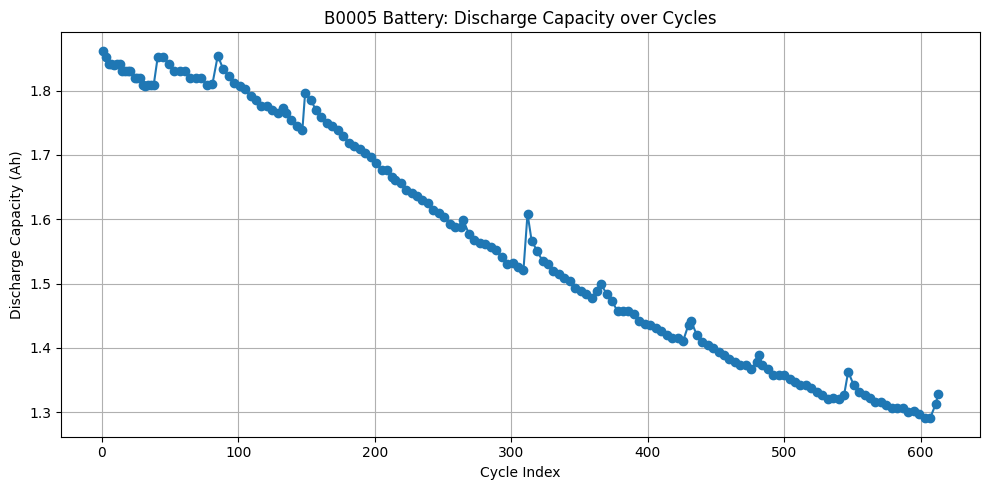

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the full dataset
df = pd.read_csv("nasa_battery_discharge_data.csv")

# Filter for B0005 only
df_b0005 = df[df['battery_id'] == 'B0005'].copy()

# Sort by cycle index (optional but good practice)
df_b0005.sort_values('cycle_index', inplace=True)

# Plot capacity vs. cycle
plt.figure(figsize=(10, 5))
plt.plot(df_b0005['cycle_index'], df_b0005['capacity_ah'], marker='o', linestyle='-')
plt.title("B0005 Battery: Discharge Capacity over Cycles")
plt.xlabel("Cycle Index")
plt.ylabel("Discharge Capacity (Ah)")
plt.grid(True)
plt.tight_layout()
plt.show()

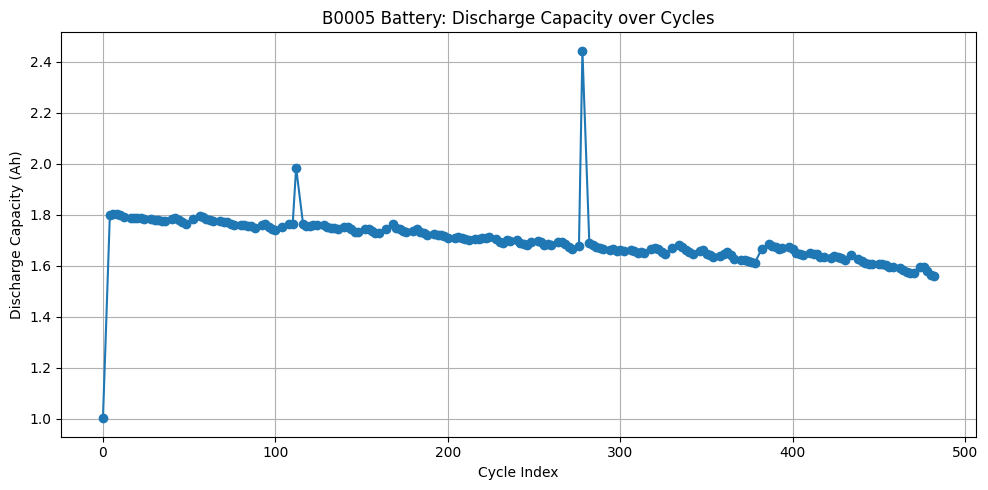

In [8]:

# Load the full dataset
df = pd.read_csv("nasa_battery_discharge_data.csv")

# Filter for B0005 only
df_b0036 = df[df['battery_id'] == 'B0036'].copy()

# Sort by cycle index (optional but good practice)
df_b0036.sort_values('cycle_index', inplace=True)

# Plot capacity vs. cycle
plt.figure(figsize=(10, 5))
plt.plot(df_b0036['cycle_index'], df_b0036['capacity_ah'], marker='o', linestyle='-')
plt.title("B0005 Battery: Discharge Capacity over Cycles")
plt.xlabel("Cycle Index")
plt.ylabel("Discharge Capacity (Ah)")
plt.grid(True)
plt.tight_layout()
plt.show()

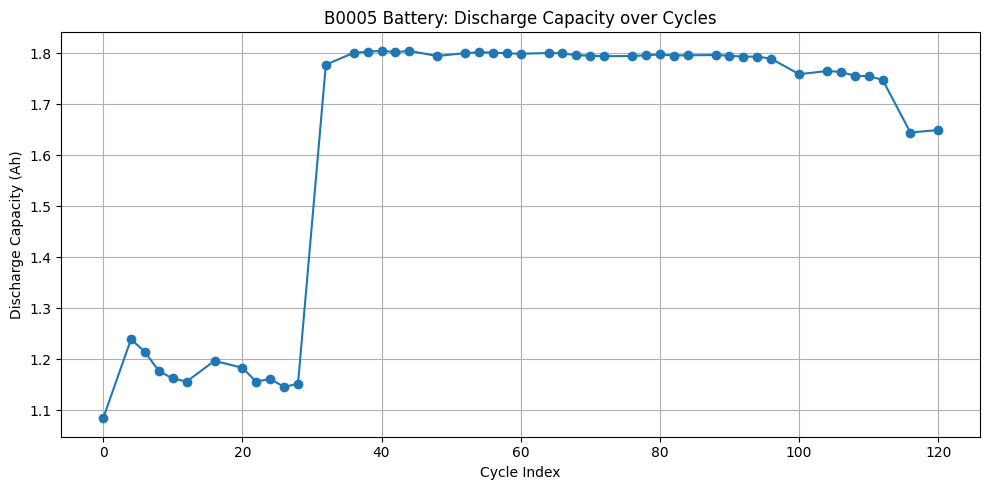

In [9]:
# Filter for B0005 only
df_b0038 = df[df['battery_id'] == 'B0038'].copy()

# Sort by cycle index (optional but good practice)
df_b0038.sort_values('cycle_index', inplace=True)

# Plot capacity vs. cycle
plt.figure(figsize=(10, 5))
plt.plot(df_b0038['cycle_index'], df_b0038['capacity_ah'], marker='o', linestyle='-')
plt.title("B0005 Battery: Discharge Capacity over Cycles")
plt.xlabel("Cycle Index")
plt.ylabel("Discharge Capacity (Ah)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Get unique battery IDs
battery_ids = df['battery_id'].unique()
print(f"Available batteries: {battery_ids}")
# Create subplot layout
n_batteries = len(battery_ids)
n_cols = 2  # 2 columns
n_rows = (n_batteries + n_cols - 1) // n_cols  # Calculate rows needed


Available batteries: ['B0005' 'B0006' 'B0007' 'B0018' 'B0025' 'B0026' 'B0027' 'B0028' 'B0029'
 'B0030' 'B0031' 'B0032' 'B0033' 'B0034' 'B0036' 'B0038' 'B0039' 'B0040'
 'B0041' 'B0042' 'B0043' 'B0044' 'B0045' 'B0046' 'B0047' 'B0048' 'B0049'
 'B0050' 'B0051' 'B0052' 'B0053' 'B0054' 'B0055' 'B0056']


Total batteries available: 34
Selected batteries: ['B0028', 'B0006', 'B0040', 'B0056', 'B0053', 'B0025']


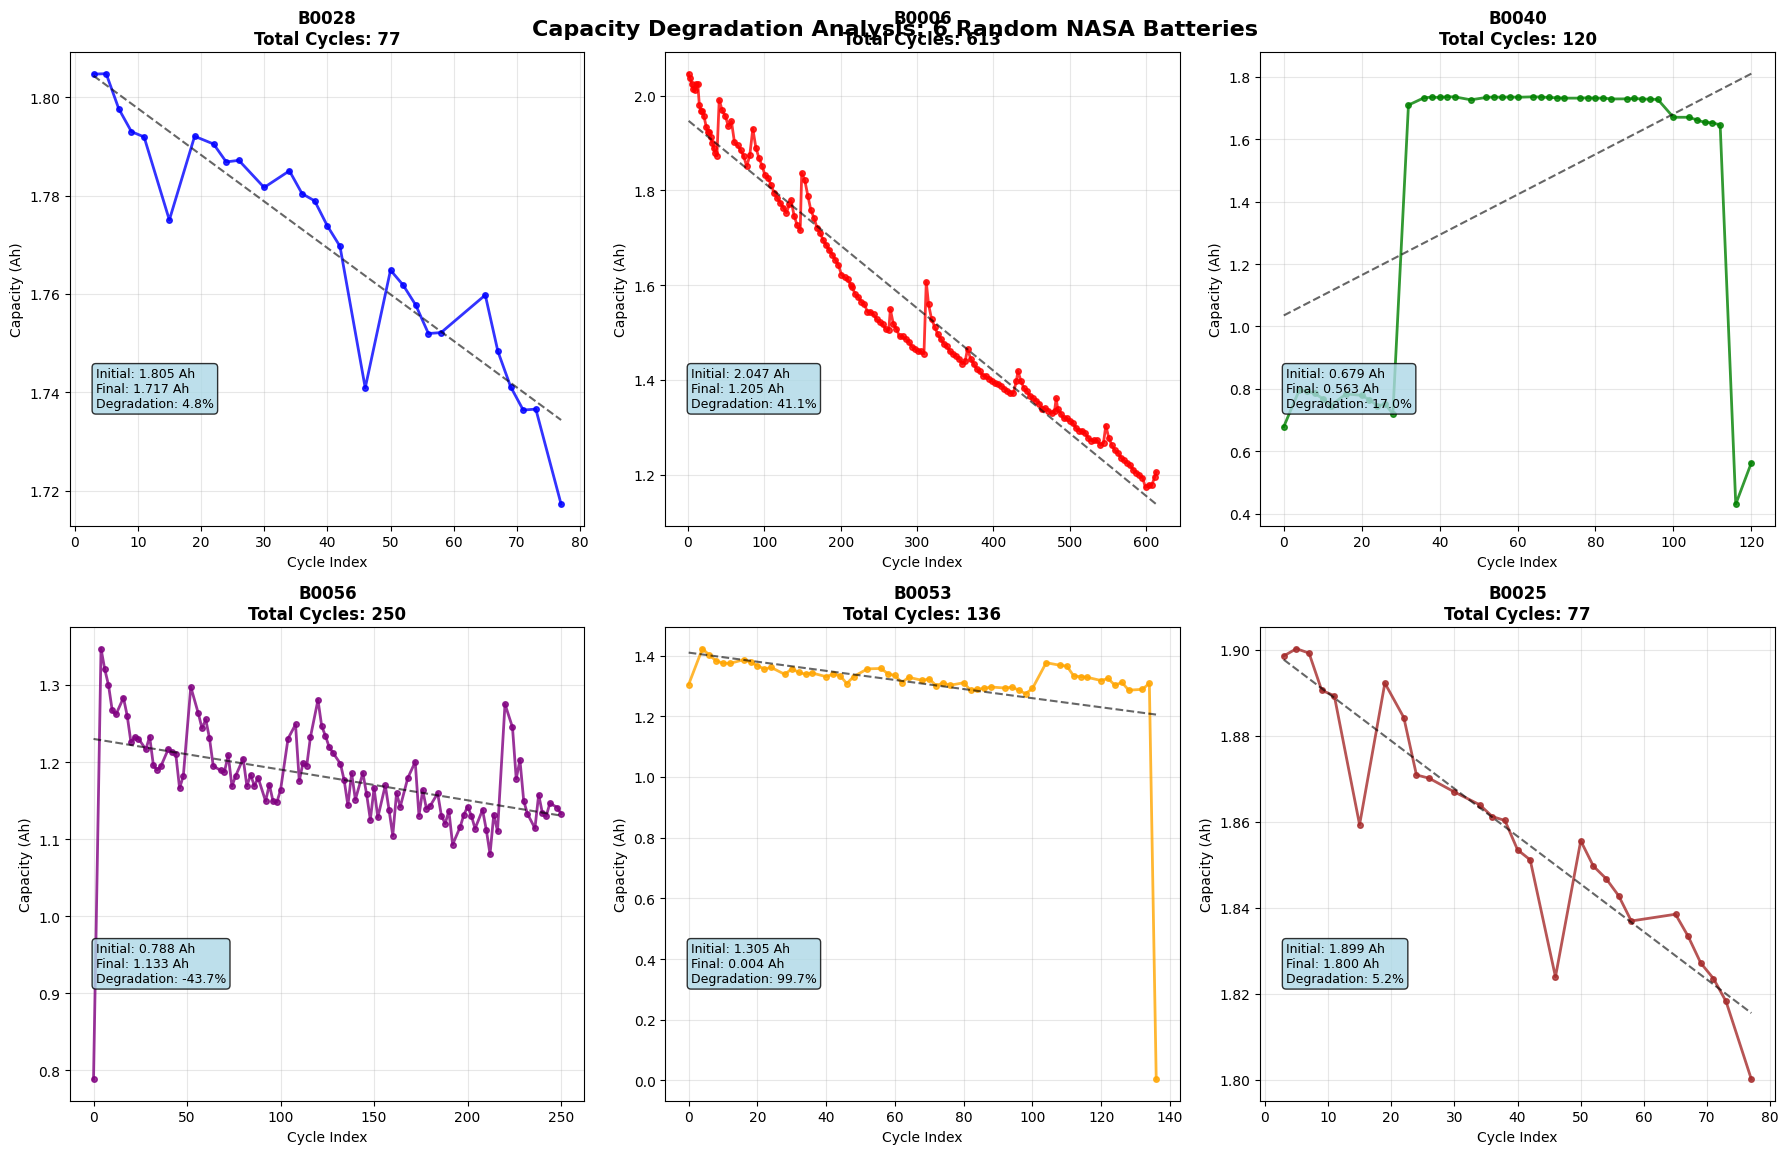

In [17]:
import random
# Get all unique battery IDs
battery_ids = df['battery_id'].unique()
print(f"Total batteries available: {len(battery_ids)}")

# Randomly select 6 batteries
random.seed(42)  # For reproducible results
selected_batteries = random.sample(list(battery_ids), 6)
print(f"Selected batteries: {selected_batteries}")

# Create 2x3 subplot layout
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Capacity Degradation Analysis: 6 Random NASA Batteries', 
             fontsize=16, fontweight='bold', y=0.95)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

# Colors for different batteries
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']

for i, battery_id in enumerate(selected_batteries):
    # Filter data for current battery
    df_battery = df[df['battery_id'] == battery_id].copy()
    df_battery = df_battery.sort_values('cycle_index')
    
    # Plot capacity vs cycles
    axes_flat[i].plot(df_battery['cycle_index'], df_battery['capacity_ah'], 
                      'o-', color=colors[i], markersize=4, linewidth=2, alpha=0.8)
    
    # Calculate statistics
    initial_capacity = df_battery['capacity_ah'].iloc[0]
    final_capacity = df_battery['capacity_ah'].iloc[-1]
    total_cycles = df_battery['cycle_index'].max()
    degradation = ((initial_capacity - final_capacity) / initial_capacity) * 100
    
    # Add trend line
    if len(df_battery) > 2:
        z = np.polyfit(df_battery['cycle_index'], df_battery['capacity_ah'], 1)
        p = np.poly1d(z)
        axes_flat[i].plot(df_battery['cycle_index'], p(df_battery['cycle_index']), 
                         '--', color='black', alpha=0.6, linewidth=1.5)
    
    # Customize subplot
    axes_flat[i].set_title(f'{battery_id}\nTotal Cycles: {total_cycles}', 
                          fontweight='bold', fontsize=12)
    axes_flat[i].set_xlabel('Cycle Index', fontsize=10)
    axes_flat[i].set_ylabel('Capacity (Ah)', fontsize=10)
    axes_flat[i].grid(True, alpha=0.3)
    
    # Add statistics text box
    stats_text = f'Initial: {initial_capacity:.3f} Ah\nFinal: {final_capacity:.3f} Ah\nDegradation: {degradation:.1f}%'
    axes_flat[i].text(0.05, 0.25, stats_text, transform=axes_flat[i].transAxes, 
                     fontsize=9, bbox=dict(boxstyle="round,pad=0.3", 
                     facecolor="lightblue", alpha=0.8))
    
    

plt.tight_layout()
plt.show()



In [12]:

# 2. Get the initial capacity for each battery
df['cap_init'] = df.groupby('battery_id')['capacity_ah'].transform('first')

# 3. Compute normalized capacity
df['cap_norm'] = df['capacity_ah'] / df['cap_init']

# 4. Classify into health states
df['health_state'] = pd.cut(
    df['cap_norm'],
    bins=[0, 0.8, 0.9, np.inf],  # boundaries for critical, degraded, healthy
    labels=['critical', 'degraded', 'healthy'],
    right=False
)

# 5. Check distribution of states
print(df['health_state'].value_counts())

# 6. Optional: check per battery
state_counts = df.groupby(['battery_id', 'health_state']).size().unstack(fill_value=0)
print(state_counts.head())


health_state
healthy     1768
critical     703
degraded     323
Name: count, dtype: int64
health_state  critical  degraded  healthy
battery_id                               
B0005               68        37       63
B0006              108        26       34
B0007               45        59       64
B0018               56        38       38
B0025                0         0       28


/tmp/ipykernel_36/3732009882.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_counts = df.groupby(['battery_id', 'health_state']).size().unstack(fill_value=0)


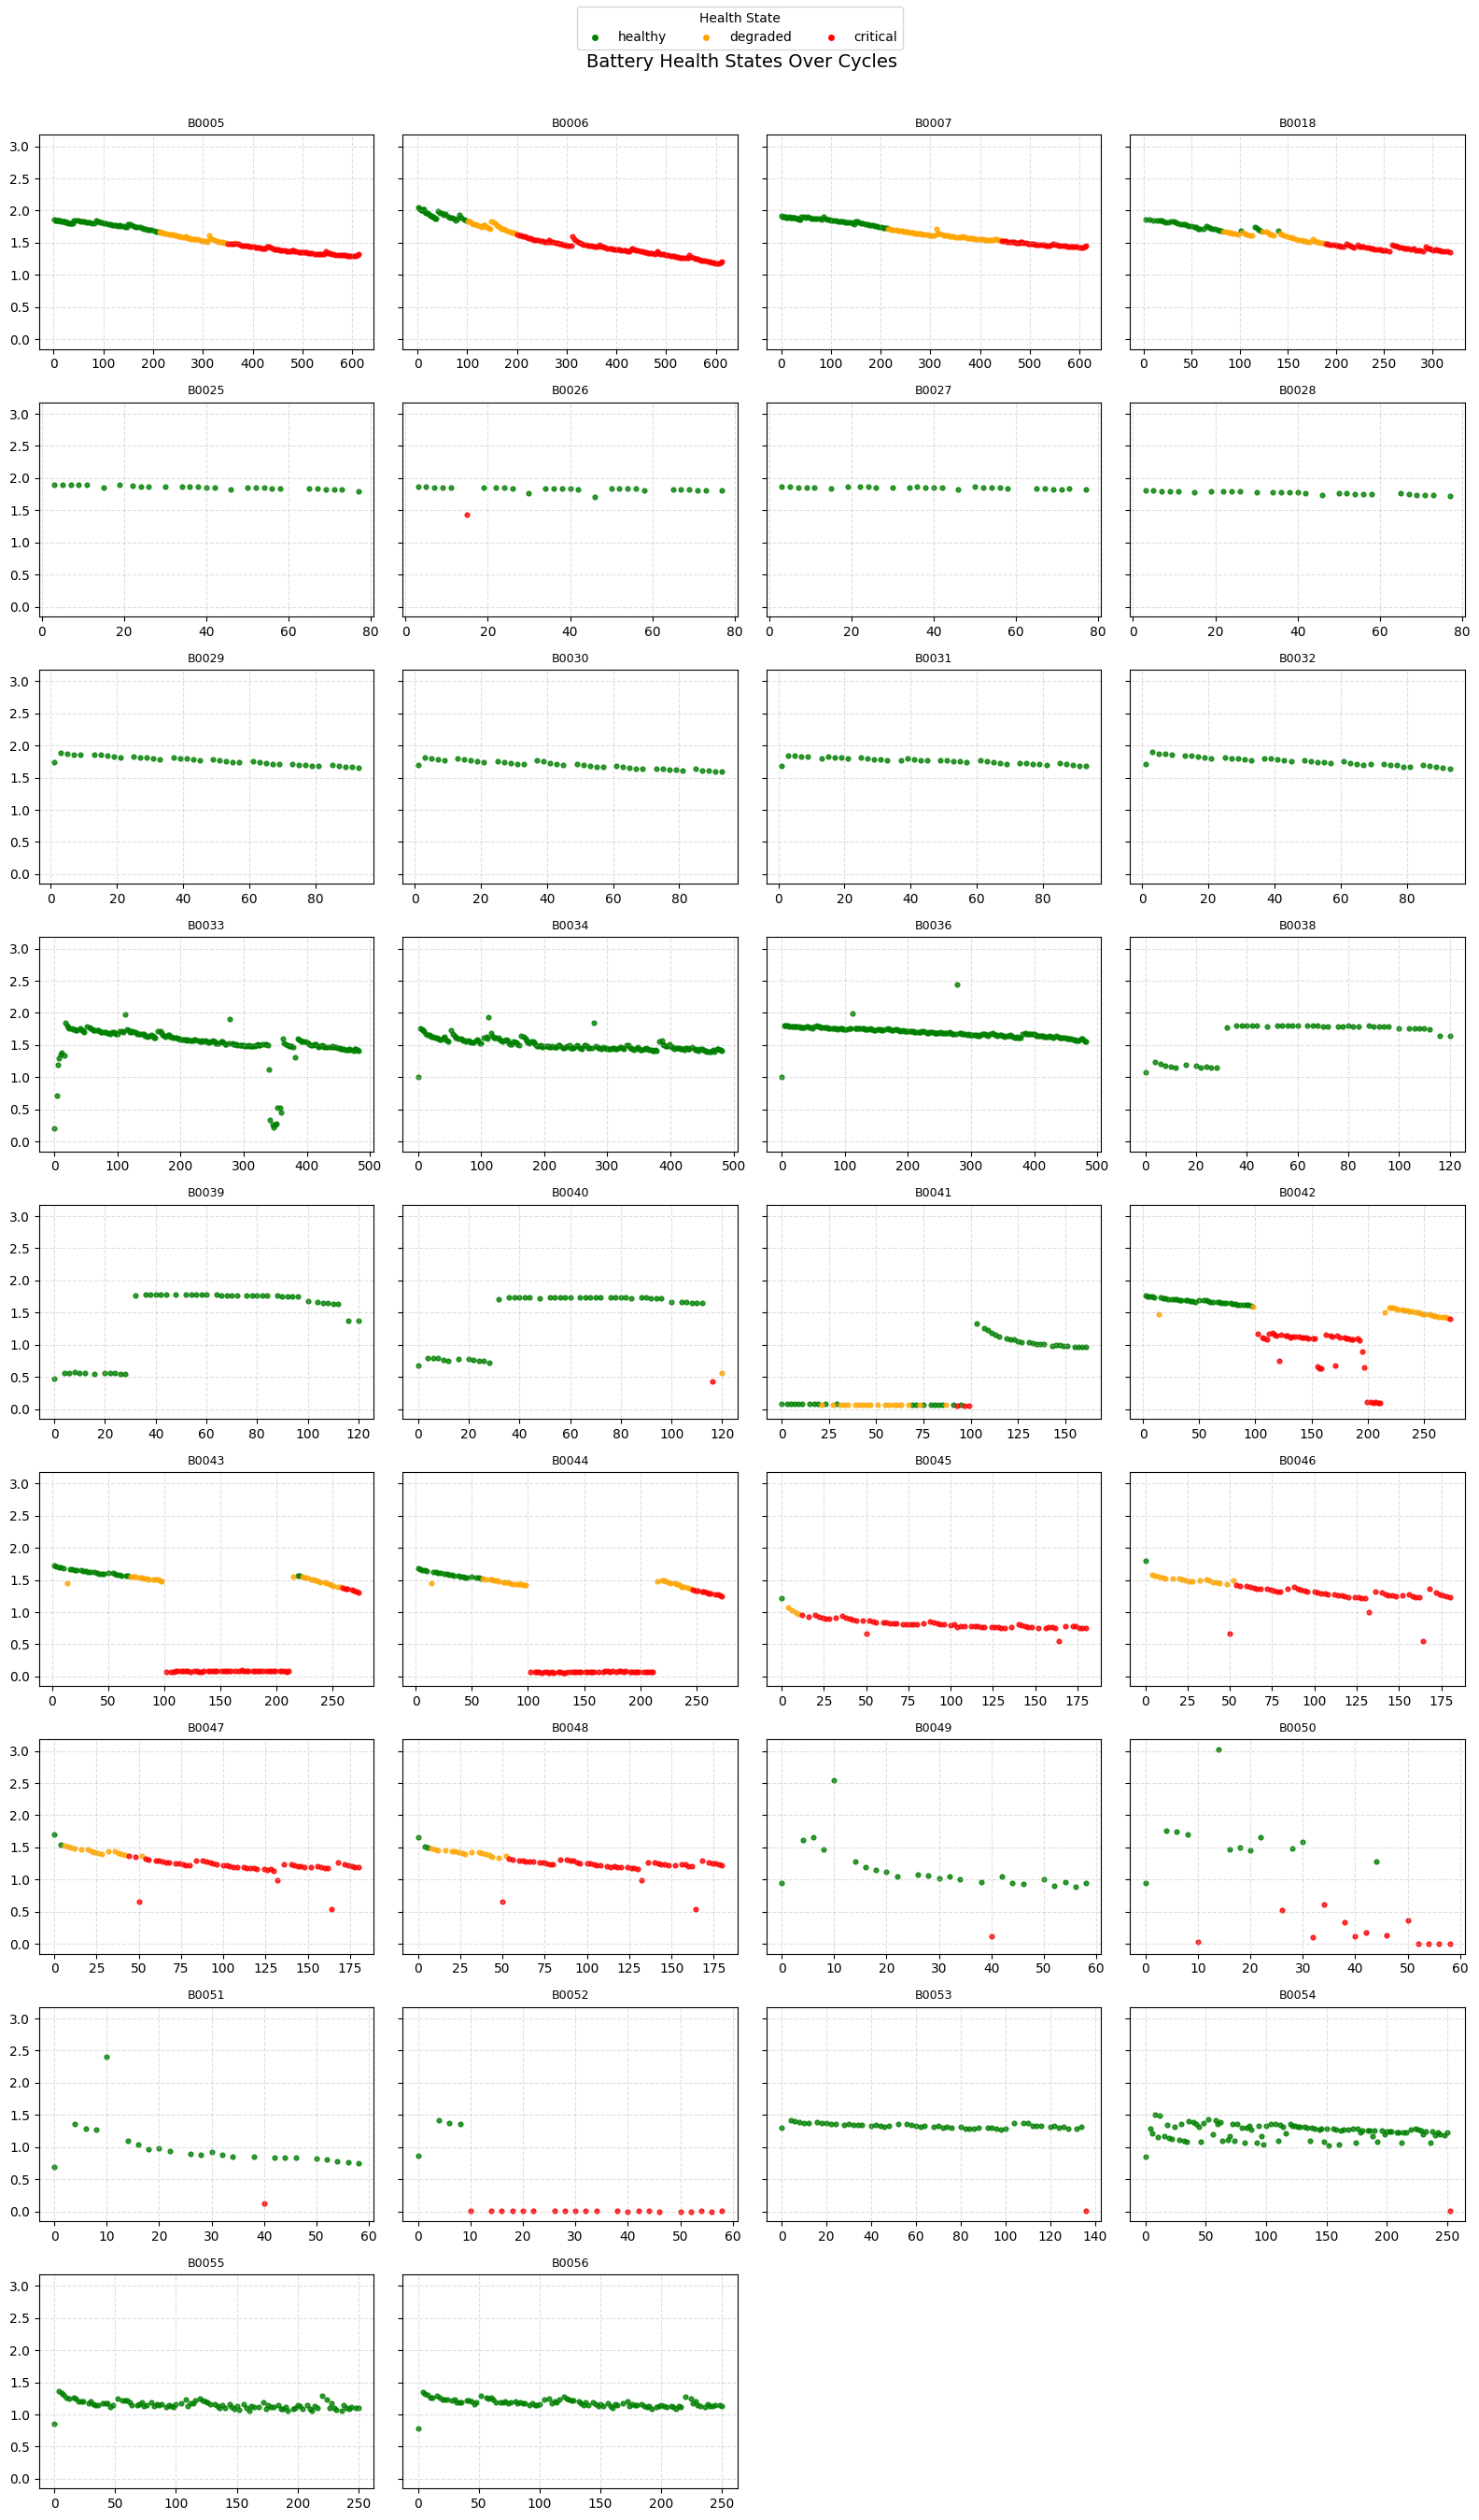

In [13]:
import matplotlib.pyplot as plt
import math

# Sort for consistency
df.sort_values(['battery_id', 'cycle_index'], inplace=True)

# Color map for health states
colors_map = {'healthy': 'green', 'degraded': 'orange', 'critical': 'red'}

# Unique batteries
batteries = df['battery_id'].unique()
n_batteries = len(batteries)

# Subplot layout
cols = 4
rows = math.ceil(n_batteries / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3), sharex=False, sharey=True)
axes = axes.flatten()

for i, bid in enumerate(batteries):
    ax = axes[i]
    db = df[df['battery_id'] == bid]
    
    for state, color in colors_map.items():
        subset = db[db['health_state'] == state]
        ax.scatter(subset['cycle_index'], subset['capacity_ah'], color=color, s=12, alpha=0.8)
    
    ax.set_title(bid, fontsize=9)
    ax.grid(True, linestyle='--', alpha=0.4)

# Remove extra subplots
for ax in axes[n_batteries:]:
    fig.delaxes(ax)

# Global legend
handles = [plt.Line2D([0],[0], marker='o', linestyle='', markerfacecolor=color, color='w', label=state, markersize=6)
           for state, color in colors_map.items()]
fig.legend(handles=handles, loc='upper center', ncol=3, title="Health State")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle("Battery Health States Over Cycles", fontsize=14)
plt.show()


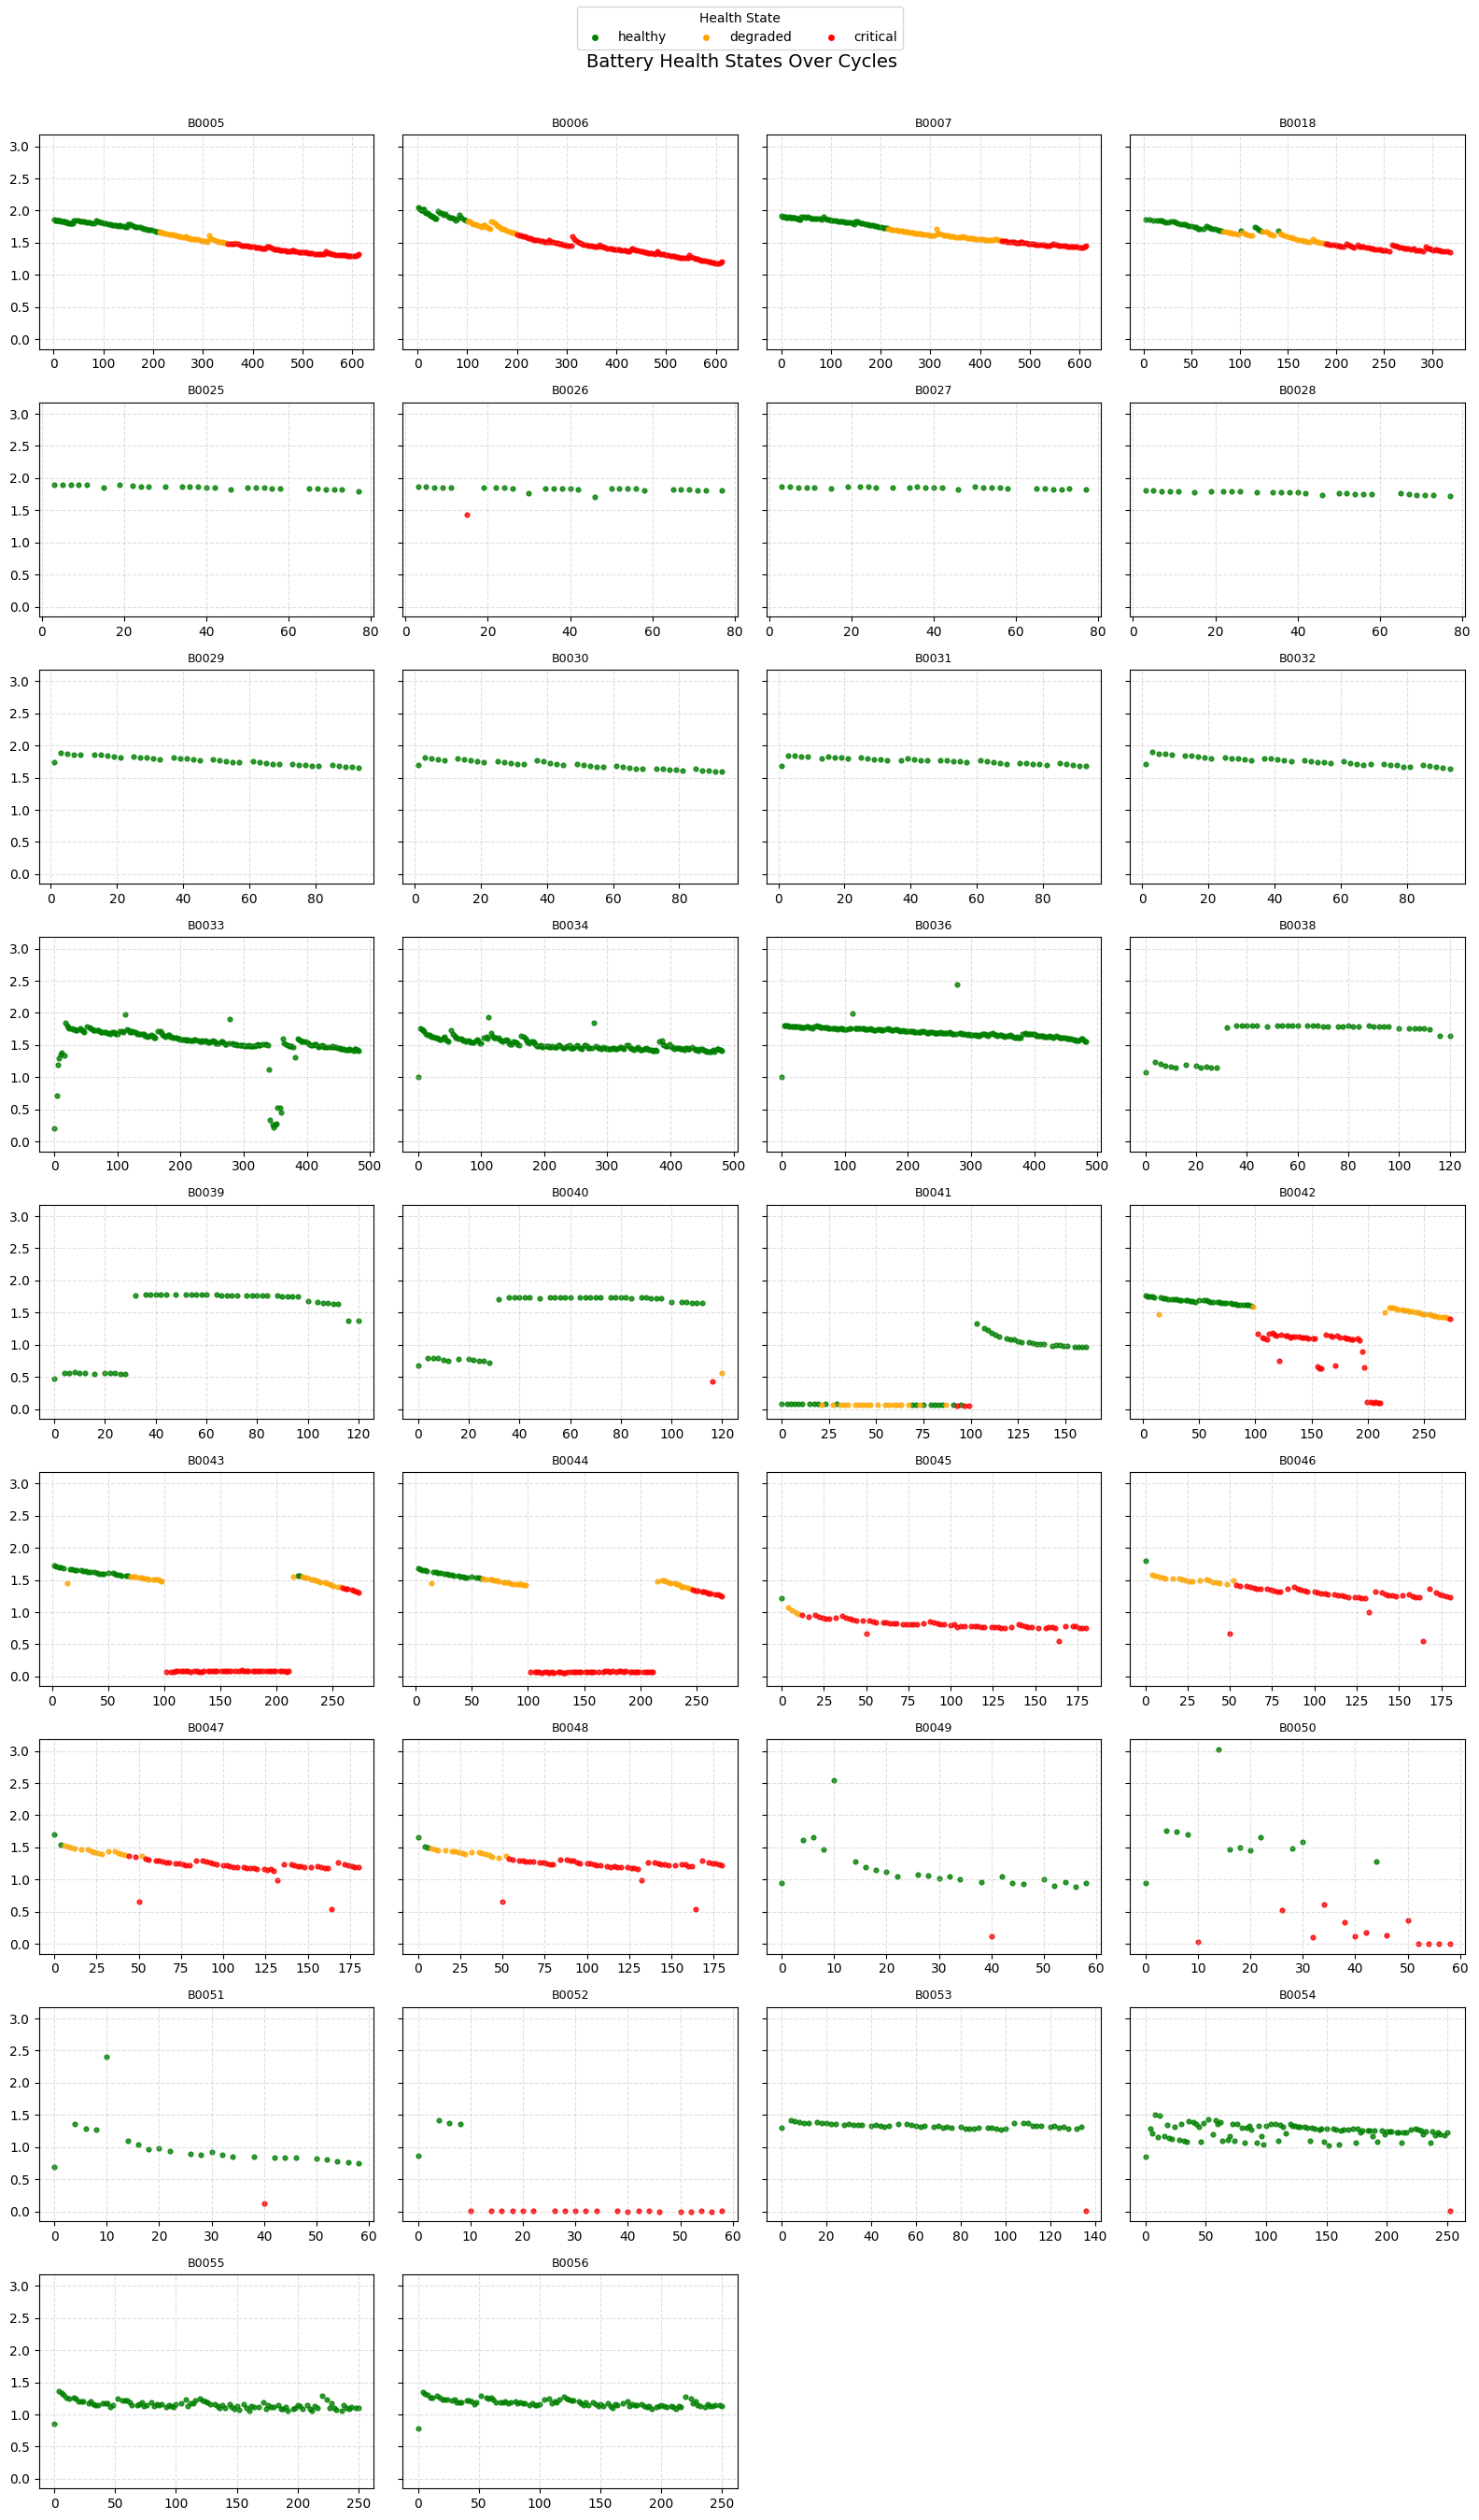

In [25]:
import matplotlib.pyplot as plt
import math

# Sort for consistency
df.sort_values(['battery_id', 'cycle_index'], inplace=True)

# Color map for health states
colors_map = {'healthy': 'green', 'degraded': 'orange', 'critical': 'red'}

# Unique batteries
batteries = df['battery_id'].unique()
n_batteries = len(batteries)

# Subplot layout
cols = 4
rows = math.ceil(n_batteries / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3), sharex=False, sharey=True)
axes = axes.flatten()

for i, bid in enumerate(batteries):
    ax = axes[i]
    db = df[df['battery_id'] == bid]
    
    for state, color in colors_map.items():
        subset = db[db['health_state'] == state]
        ax.scatter(subset['cycle_index'], subset['capacity_ah'], color=color, s=12, alpha=0.8)
    
    ax.set_title(bid, fontsize=9)
    ax.grid(True, linestyle='--', alpha=0.4)

# Remove extra subplots
for ax in axes[n_batteries:]:
    fig.delaxes(ax)

# Global legend
handles = [plt.Line2D([0],[0], marker='o', linestyle='', markerfacecolor=color, color='w', label=state, markersize=6)
           for state, color in colors_map.items()]
fig.legend(handles=handles, loc='upper center', ncol=3, title="Health State")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle("Battery Health States Over Cycles", fontsize=14)
plt.show()


In [14]:
from sklearn.preprocessing import StandardScaler

# Normalize
features = ["avg_voltage","min_voltage","max_voltage",
            "avg_current","max_current","avg_temperature"]

scaler = StandardScaler()
X = scaler.fit_transform(df[features])

df_scaled = df.copy()
df_scaled[features] = X

In [15]:
def add_health_and_failure(df):
    df = df.copy()
    df["health_state"] = None
    df["failure_cycle"] = np.nan
    
    for bid in df["battery_id"].unique():
        bdata = df[df["battery_id"] == bid]
        cap0 = bdata["capacity_ah"].iloc[0]   # first cycle capacity
        failure_cycle = None
        
        for idx, row in bdata.iterrows():
            cap = row["capacity_ah"]
            if cap >= 0.8 * cap0:
                state = "healthy"
            elif cap >= 0.6 * cap0:
                state = "degraded"
            else:
                state = "critical"
                if failure_cycle is None:
                    failure_cycle = row["cycle_index"]
            df.at[idx, "health_state"] = state
        
        # Assign same failure_cycle to all rows of this battery
        df.loc[df["battery_id"] == bid, "failure_cycle"] = failure_cycle
    
    return df

df_labeled = add_health_and_failure(df)

In [16]:
features = ["avg_voltage","min_voltage","max_voltage",
            "avg_current","max_current","avg_temperature"]

# Standardize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_labeled[features] = scaler.fit_transform(df_labeled[features])

# Train on healthy+degraded only
train_df = df_labeled[df_labeled["health_state"].isin(["healthy","degraded"])]
test_df  = df_labeled.copy()

X_train = train_df[features].values
X_test  = test_df[features].values

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_dim = len(features)

def build_autoencoder(input_dim):
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(32, activation="relu")(inp)
    x = layers.Dense(16, activation="relu")(x)
    bottleneck = layers.Dense(8, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(bottleneck)
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(input_dim, activation=None)(x)  # reconstruct raw scaled features
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    return model

ae = build_autoencoder(input_dim)
history = ae.fit(
    X_train, X_train,
    validation_split=0.1,
    epochs=50,
    batch_size=64,
    shuffle=True,
    verbose=1
)


2025-08-17 16:11:56.877745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755447117.219943      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755447117.313923      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1755447135.263346      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755447135.264105      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

Epoch 1/50


I0000 00:00:1755447139.494076      85 service.cc:148] XLA service 0x7910e800bd00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755447139.495353      85 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755447139.495374      85 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755447139.890493      85 cuda_dnn.cc:529] Loaded cuDNN version 90300


24/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6742 

I0000 00:00:1755447141.249108      85 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.6564 - val_loss: 0.4188
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4802 - val_loss: 0.3220
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3742 - val_loss: 0.2930
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2262 - val_loss: 0.2191
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1218 - val_loss: 0.1403
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0552 - val_loss: 0.0707
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0292 - val_loss: 0.0486
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0236 - val_loss: 0.0440
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0203 - val_loss: 0.0302
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0164 - val_loss: 0.0253
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0139 - val_loss: 0.0215
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0127 - val_loss: 0.0176

In [18]:
# Training reconstruction error distribution (for threshold)
train_recon = ae.predict(X_train, verbose=0)
train_err = np.mean((train_recon - X_train)**2, axis=1)

# A common choice: mean + 3*std (or use a percentile for robustness)
thr_gauss = train_err.mean() + 3*train_err.std()
thr_pct   = np.percentile(train_err, 97)  # 99th percentile

threshold = thr_pct  # pick one; percentile is often more robust
print("Chosen anomaly threshold:", threshold)

# Test-time reconstruction error
test_recon = ae.predict(X_test, verbose=0)
test_err = np.mean((test_recon - X_test)**2, axis=1)

test_df["recon_error"] = test_err
test_df["anomaly"] = (test_df["recon_error"] > threshold).astype(int)

Chosen anomaly threshold: 0.007065643463097315


In [19]:
def early_at_k_score(df, k=5):
    scores = []
    for bid in df["battery_id"].unique():
        b = df[df["battery_id"] == bid].sort_values("cycle_index")
        failure_cycle = b["failure_cycle"].iloc[0]
        if np.isnan(failure_cycle):   # no failure observed => skip battery
            continue
        flagged_cycles = b.loc[b["anomaly"]==1, "cycle_index"].values
        success = int(any(cyc <= failure_cycle - k for cyc in flagged_cycles))
        scores.append(success)
    if len(scores) == 0:
        return None
    return float(np.mean(scores))

early5 = early_at_k_score(test_df, k=5)
print("EARLY@5 Success Rate:", early5)


EARLY@5 Success Rate: 0.5


In [20]:
# Recompute with a lower percentile threshold
for pct in [97.5, 98, 98.5, 99]:
    thr = np.percentile(train_err, pct)
    tmp = test_df.copy()
    tmp["anomaly"] = (tmp["recon_error"] > thr).astype(int)
    print(f"pct={pct}  anomalies per battery:\n", tmp.groupby("battery_id")["anomaly"].sum(), "\n")


pct=97.5  anomalies per battery:
 battery_id
B0005     0
B0006     0
B0007     0
B0018     0
B0025     0
B0026     1
B0027     4
B0028     0
B0029     1
B0030     1
B0031     0
B0032     1
B0033     5
B0034     3
B0036     3
B0038     2
B0039     3
B0040     2
B0041     4
B0042    10
B0043    47
B0044    46
B0045     2
B0046     5
B0047     3
B0048     3
B0049     3
B0050    16
B0051     3
B0052    22
B0053     2
B0054     3
B0055     6
B0056    13
Name: anomaly, dtype: int64 

pct=98  anomalies per battery:
 battery_id
B0005     0
B0006     0
B0007     0
B0018     0
B0025     0
B0026     1
B0027     3
B0028     0
B0029     1
B0030     0
B0031     0
B0032     1
B0033     5
B0034     3
B0036     3
B0038     1
B0039     3
B0040     2
B0041     3
B0042     8
B0043    47
B0044    46
B0045     2
B0046     3
B0047     3
B0048     3
B0049     3
B0050    16
B0051     3
B0052    22
B0053     2
B0054     3
B0055     4
B0056     8
Name: anomaly, dtype: int64 

pct=98.5  anomalies per battery:
 ba

In [23]:
for pct in [88, 90, 97.5, 98, 98.5, 99]:
    thr = np.percentile(train_err, pct)
    tmp = test_df.copy()
    tmp["anomaly"] = (tmp["recon_error"] > thr).astype(int)
    score = early_at_k_score(tmp, k=5)
    print(f"pct={pct}, EARLY@5 = {score:.3f}")

pct=88, EARLY@5 = 0.857
pct=90, EARLY@5 = 0.786
pct=97.5, EARLY@5 = 0.500
pct=98, EARLY@5 = 0.429
pct=98.5, EARLY@5 = 0.357
pct=99, EARLY@5 = 0.357


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


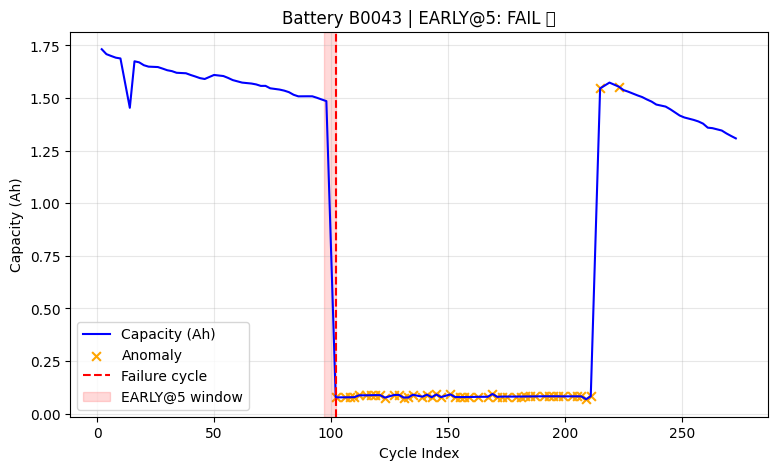

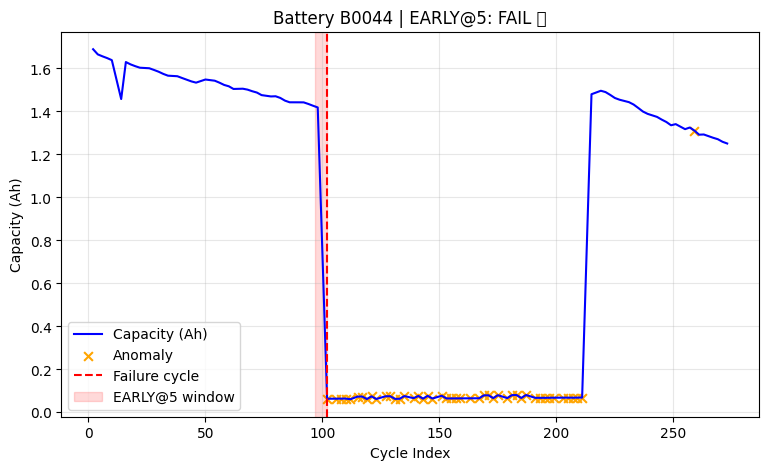

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


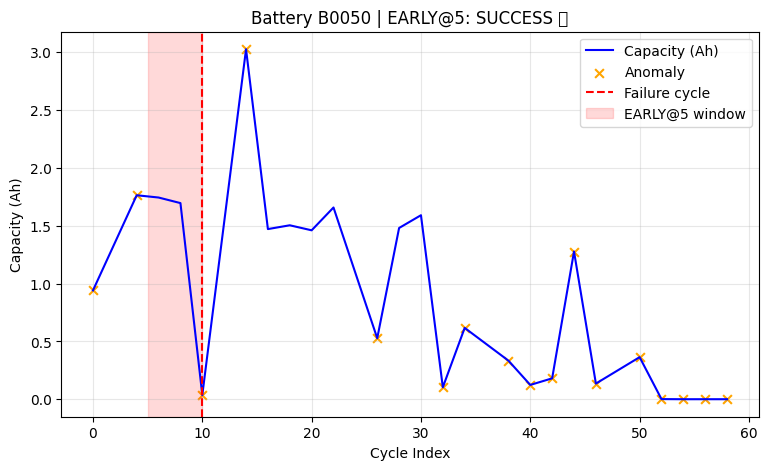

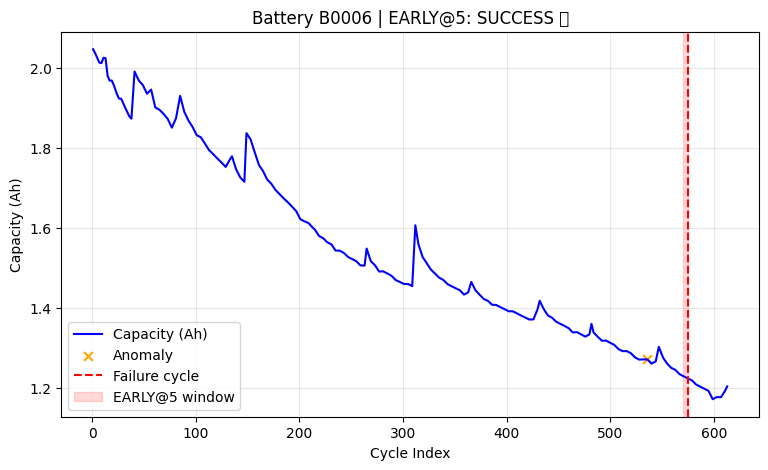

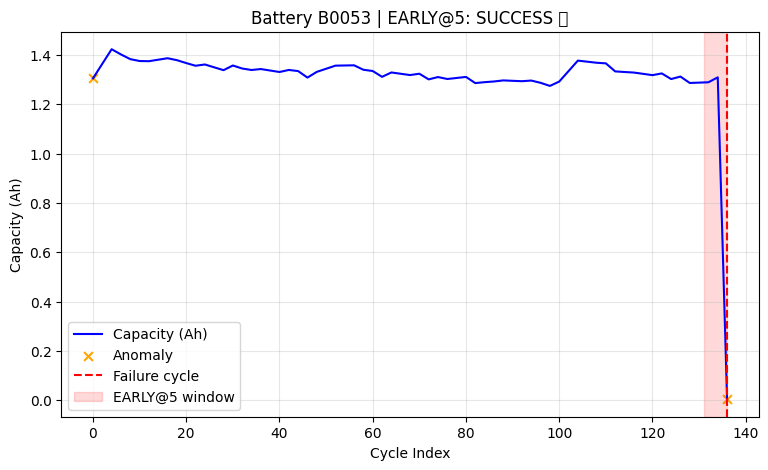

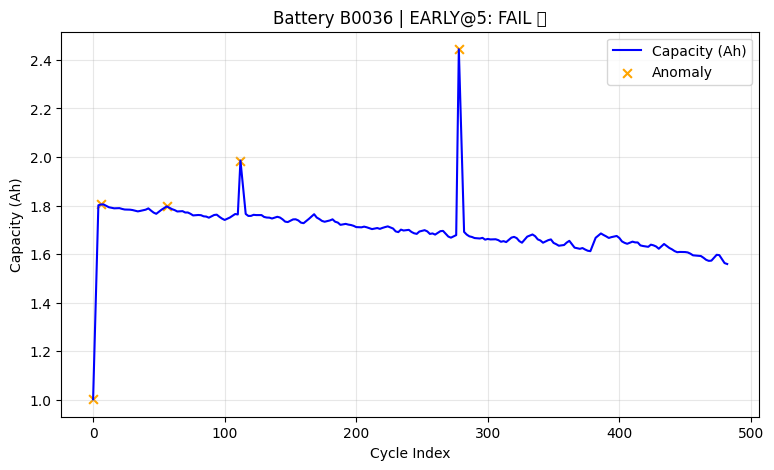

In [24]:
# --- Recompute anomalies at 97.5% threshold ---
thr = np.percentile(train_err, 88)
test_df["anomaly_975"] = (test_df["recon_error"] > thr).astype(int)

# --- Plot function with EARLY@5 status ---
import matplotlib.pyplot as plt

def plot_battery_predictions(df, bid, col="anomaly_975", k=5):
    b = df[df["battery_id"] == bid].sort_values("cycle_index")
    fc = b["failure_cycle"].iloc[0]
    flagged = b[b[col]==1]

    success = False
    if not np.isnan(fc):
        success = any(flagged["cycle_index"] <= fc - k)

    plt.figure(figsize=(9,5))
    plt.plot(b["cycle_index"], b["capacity_ah"], label="Capacity (Ah)", color="blue")
    if not flagged.empty:
        plt.scatter(flagged["cycle_index"], flagged["capacity_ah"], 
                    color="orange", s=40, marker="x", label="Anomaly")
    if not np.isnan(fc):
        plt.axvline(fc, color="red", linestyle="--", label="Failure cycle")
        plt.axvspan(fc-k, fc, alpha=0.15, color="red", label=f"EARLY@{k} window")

    status = "SUCCESS ✅" if success else "FAIL ❌"
    plt.title(f"Battery {bid} | EARLY@{k}: {status}")
    plt.xlabel("Cycle Index"); plt.ylabel("Capacity (Ah)")
    plt.legend(); plt.grid(True, alpha=0.3); plt.show()

# --- Example batteries ---
for bid in ["B0043","B0044","B0050","B0006", "B0053", "B0036"]:  # mix of good and weak predictions
    plot_battery_predictions(test_df, bid, col="anomaly_975", k=5)

In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score

def apply_persistence(df, pred_col, out_col="anomaly_smooth", window=3):
    # rolling max of predicted anomalies per battery
    df = df.sort_values(["battery_id","cycle_index"]).copy()
    df[out_col] = (df
        .groupby("battery_id")[pred_col]
        .transform(lambda x: x.rolling(window, min_periods=1).max()))
    return df

def early_at_k(df, pred_col="anomaly", k=5):
    scores = []
    for bid, b in df.groupby("battery_id", sort=False):
        fc = b["failure_cycle"].iloc[0]
        if np.isnan(fc):  # skip stable batteries (no failure)
            continue
        flagged = b.loc[b[pred_col]==1, "cycle_index"].values
        success = int(any(c <= fc - k for c in flagged))
        scores.append(success)
    return None if not scores else float(np.mean(scores))

def battery_level_confusion(df, pred_col="anomaly"):
    # counts batteries, not cycles
    tp=fp=tn=fn=0
    for bid, b in df.groupby("battery_id", sort=False):
        has_failure = not np.isnan(b["failure_cycle"]).all()
        flagged_any = (b[pred_col]==1).any()
        if has_failure and flagged_any: tp += 1
        elif has_failure and not flagged_any: fn += 1
        elif (not has_failure) and flagged_any: fp += 1
        else: tn += 1
    return {"TP_batt":tp, "FN_batt":fn, "FP_batt":fp, "TN_batt":tn}


In [27]:
def global_percentile_threshold(train_scores, pct):
    return np.percentile(train_scores, pct)

def per_battery_percentile_threshold(df, score_col, early_frac=0.2, pct=99):
    # build per-battery adaptive thresholds from early healthy portion
    thr_map = {}
    for bid, b in df.sort_values("cycle_index").groupby("battery_id", sort=False):
        n = len(b)
        ne = max(5, int(n*early_frac))
        # prefer healthy cycles; fallback to first ne cycles
        early_b = b[b["health_state"]=="healthy"].head(ne)
        if len(early_b) < 5:
            early_b = b.head(ne)
        thr_map[bid] = np.percentile(early_b[score_col].values, pct)
    return thr_map


In [28]:
def evaluate_across_thresholds(
    df,
    score_col="recon_error",
    train_scores=None,                 # required for global percentile thresholds
    thresholds_pct=(88, 90, 97.5, 98, 98.5, 99),
    ks=(3,5,10),
    use_per_battery=False,
    early_frac=0.2,
    persistence_window=3
):
    df = df.sort_values(["battery_id","cycle_index"]).copy()

    # ground truth for anomaly metrics (point-wise)
    y_true = (df["health_state"]=="critical").astype(int).values
    # guard for ROC/PR when positives or negatives are missing
    roc_ok = (y_true.sum() > 0) and (y_true.sum() < len(y_true))

    rows = []
    for pct in thresholds_pct:
        tmp = df.copy()
        if use_per_battery:
            thr_map = per_battery_percentile_threshold(tmp, score_col, early_frac=early_frac, pct=pct)
            tmp["anomaly_raw"] = [int(s > thr_map[bid]) for bid, s in zip(tmp["battery_id"], tmp[score_col])]
        else:
            assert train_scores is not None, "Provide train_scores for global thresholding."
            thr = global_percentile_threshold(train_scores, pct)
            tmp["anomaly_raw"] = (tmp[score_col] > thr).astype(int)

        # apply persistence rule
        tmp = apply_persistence(tmp, "anomaly_raw", out_col="anomaly", window=persistence_window)

        # point-wise metrics at this operating point
        y_pred = tmp["anomaly"].values
        P = precision_score(y_true, y_pred, zero_division=0)
        R = recall_score(y_true, y_pred, zero_division=0)
        F1 = f1_score(y_true, y_pred, zero_division=0)

        # curves (threshold-free) using score_col
        roc = roc_auc_score(y_true, tmp[score_col].values) if roc_ok else np.nan
        pr_auc = average_precision_score(y_true, tmp[score_col].values) if y_true.sum()>0 else np.nan

        # battery-level false alarms on stable batteries
        batt_conf = battery_level_confusion(tmp, pred_col="anomaly")
        stable_batts = batt_conf["FP_batt"] + batt_conf["TN_batt"]
        false_alarm_rate = (batt_conf["FP_batt"] / stable_batts) if stable_batts > 0 else np.nan

        # EARLY@k
        early_scores = {f"EARLY@{k}": early_at_k(tmp, pred_col="anomaly", k=k) for k in ks}

        rows.append({
            "threshold_pct": pct,
            "use_per_batt": use_per_battery,
            "persistence": persistence_window,
            "Precision": P, "Recall": R, "F1": F1,
            "ROC_AUC": roc, "PR_AUC": pr_auc,
            "FalseAlarmRate_stableBatt": false_alarm_rate,
            **early_scores
        })

    return pd.DataFrame(rows).sort_values(["use_per_batt","threshold_pct"]).reset_index(drop=True)


In [29]:
# If you trained an AE/LSTM-AE on normal data:
# train_err = np.mean((train_recon - X_train)**2, axis=...)  # your code earlier
# test_df already has recon_error (or seq_error)

summary_global = evaluate_across_thresholds(
    df=test_df,                         # your point-wise dataframe
    score_col="recon_error",            # or "seq_error"
    train_scores=train_err,
    thresholds_pct=(88,90,97.5,98,98.5,99),
    ks=(3,5,10),
    use_per_battery=False,
    persistence_window=3
)
print(summary_global)


   threshold_pct  use_per_batt  persistence  Precision    Recall        F1  \
0           88.0         False            3   0.204301  0.926829  0.334802   
1           90.0         False            3   0.225185  0.926829  0.362336   
2           97.5         False            3   0.423295  0.908537  0.577519   
3           98.0         False            3   0.460568  0.890244  0.607069   
4           98.5         False            3   0.503472  0.884146  0.641593   
5           99.0         False            3   0.586777  0.865854  0.699507   

    ROC_AUC    PR_AUC  FalseAlarmRate_stableBatt   EARLY@3   EARLY@5  EARLY@10  
0  0.957799  0.794189                       1.00  0.857143  0.857143  0.857143  
1  0.957799  0.794189                       1.00  0.785714  0.785714  0.785714  
2  0.957799  0.794189                       0.70  0.500000  0.500000  0.500000  
3  0.957799  0.794189                       0.65  0.428571  0.428571  0.428571  
4  0.957799  0.794189                       0.65

# Comparative

